# EveryBeam OSKAR SKA integration tests

Not to put a dampener on `WODEN`, but if you're using the the `OSKAR` primary beam, I would just use `OSKAR` to make visibilities. Sure, `WODEN` does precession, which `OSKAR` doesn't, but `OSKAR` has a fully GPU version of the beam which is so much faster. The `EveryBeam` `OSKAR` implementation takes a large, large amount of time to run. 

These tests are all setup and explained in `test_MWA.ipynb`. We'll look a the beam shape, test Stokes recovery, and make an image from visibilities.

Goes without saying, but these tests rely on `everybeam` being installed.

In [1]:
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
from wodenpy.primary_beam.use_everybeam import run_everybeam, run_everybeam_over_threads
import erfa
import mwa_hyperbeam
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000
from wodenpy.array_layout.create_array_layout import convert_ecef_to_enh

import sys
sys.path.append('../../scripts/')
from run_woden import main as run_woden

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

# os.environ["MWA_BEAM_FILE"] = "/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

C = c.to('m/s').value

MWA_LAT=-26.703319405555554
MWA_LONG=116.67081523611111

First up just quickly, let's see what station layout I'm using. NOW using `pycasacore` is handy, but doing a `pip install casacore` will install a different underlying `casacore` library to the one we've linked to `WODEN`. If you try and run them in the same notebook kernel, you'll get version conflicts. So in the following cell, I'm going to run a script via the command line to keep things separate.

Successful readonly open of default-locked table pointed_LBA.ms/ANTENNA: 10 columns, 37 rows
Successful readonly open of default-locked table pointed_LBA.ms::LOFAR_ANTENNA_FIELD: 9 columns, 37 rows
Successful readonly open of default-locked table pointed_LBA.ms/ANTENNA: 10 columns, 37 rows
Successful readonly open of default-locked table pointed_LBA.ms::LOFAR_ANTENNA_FIELD: 9 columns, 37 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows


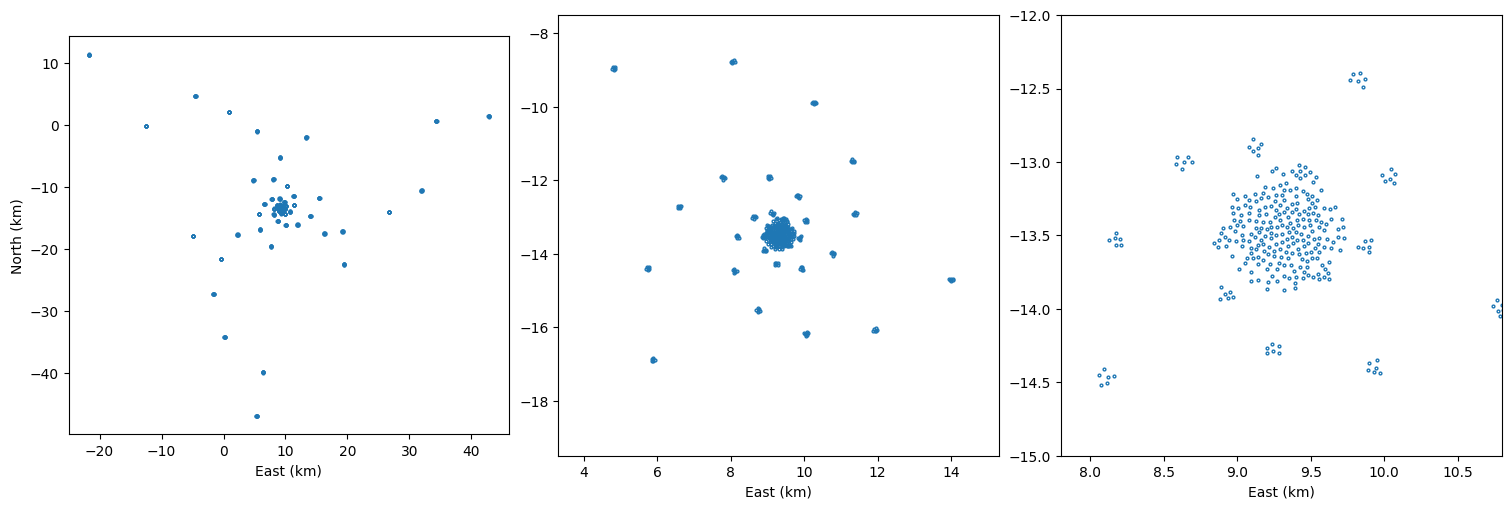

There are 512 antennas in the OSKAR-SKA layout.


In [23]:
from subprocess import call


call("python3 get_station_layouts.py", shell=True)

east, north, height = np.load('OSKAR-SKA-layout.npz').values()

east, north = east/1e3, north/1e3  #convert to km

fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

for ax in axs:
    ax.plot(east, north, 'o',mfc='none', ms=2)

edge = 6
x_cent = 9.3
y_cent = -13.5

axs[1].set_xlim(x_cent-edge, x_cent+edge)
axs[1].set_ylim(y_cent-edge, y_cent+edge)

edge = 1.5
axs[2].set_xlim(x_cent-edge, x_cent+edge)
axs[2].set_ylim(y_cent-edge, y_cent+edge)

for ax in axs:
    ax.set_xlabel('East (km)')
    ax.set_aspect('equal', 'box')
axs[0].set_ylabel('North (km)')
plt.show()

print(f"There are {len(east)} antennas in the OSKAR-SKA layout.")

### Image the beam on the sky

First up, let's see if we can just plot an OSKAR SKA station beam to check it looks sensible.

In [3]:
##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=MWA_LONG*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg")

LST: 0.0045520088542088475 deg


Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead


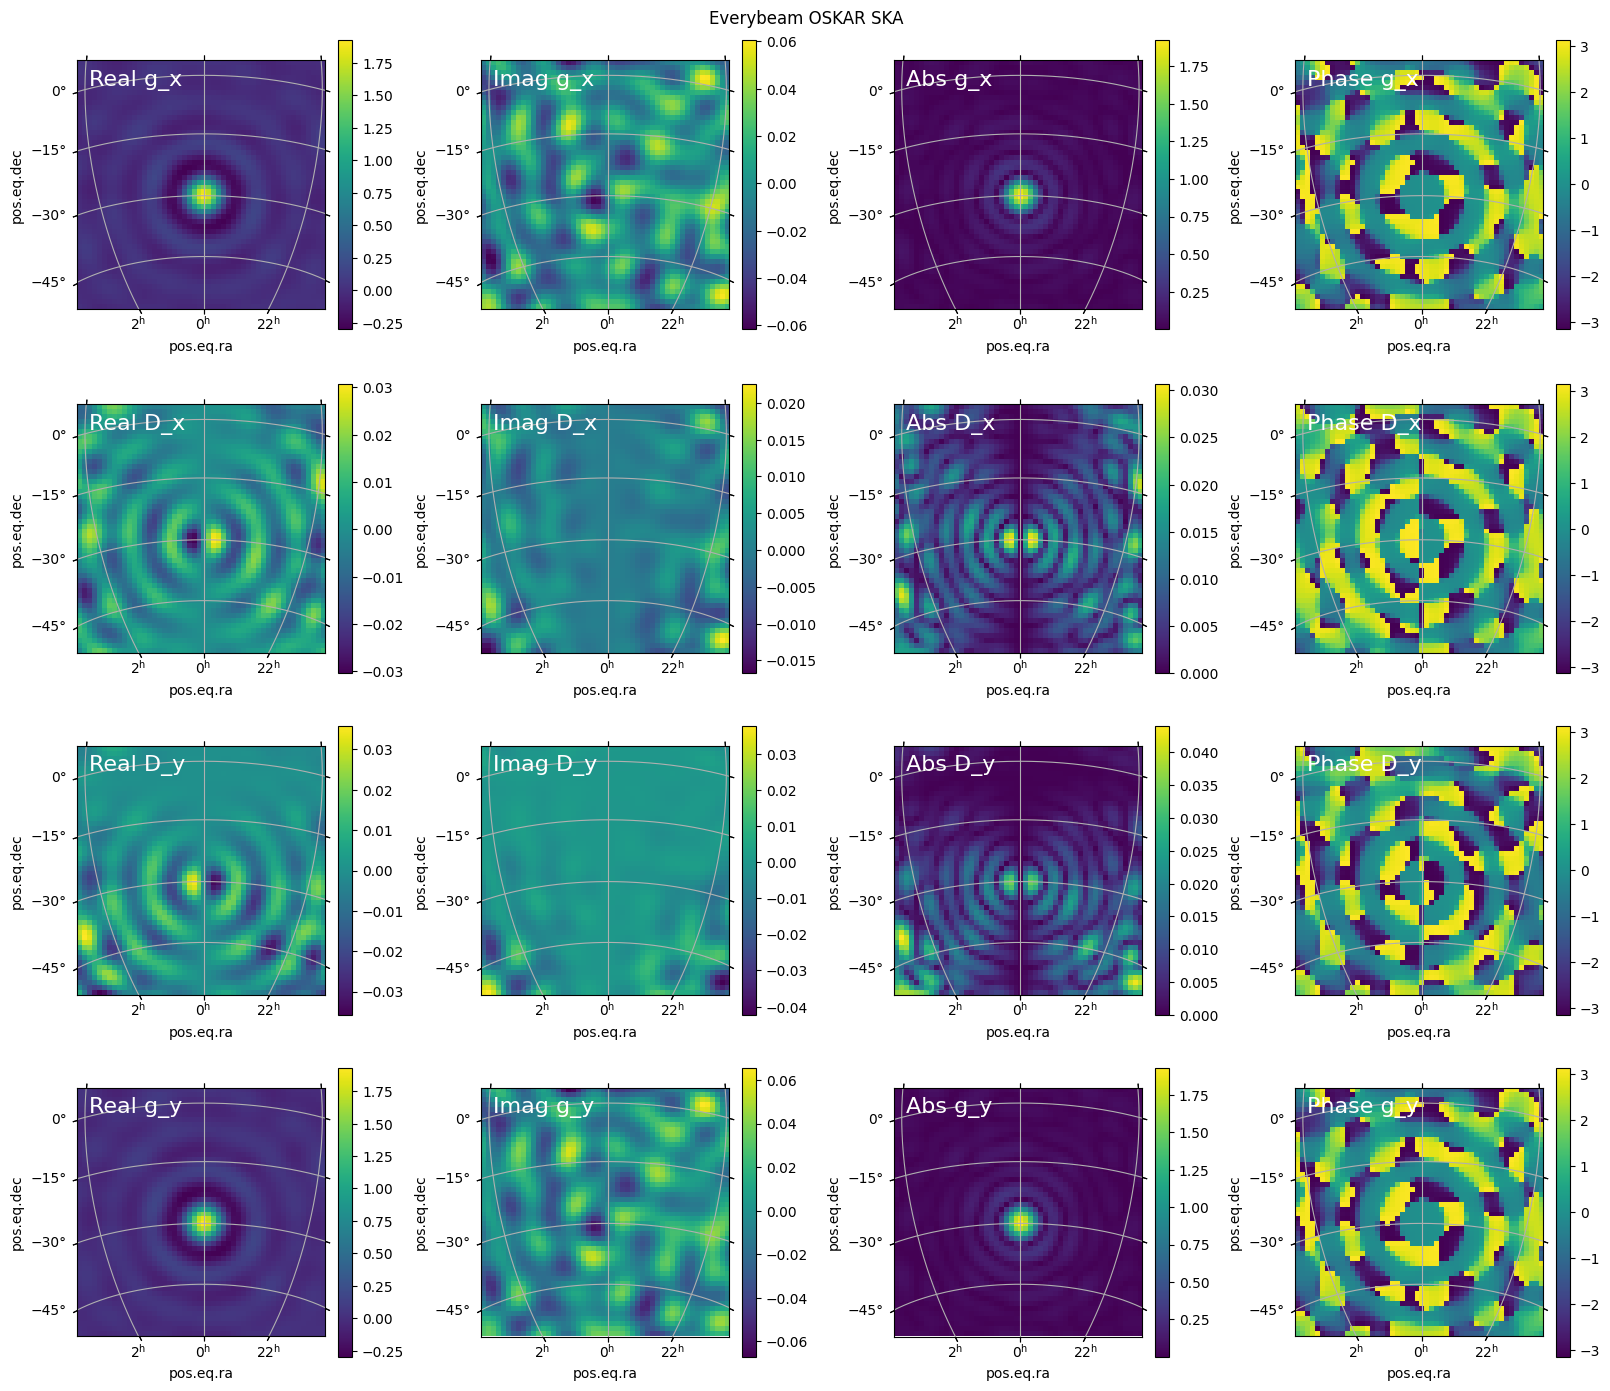

In [4]:
ms_path="create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms"

ra0 = LST_deg
dec0 = MWA_LAT

nside=50
radec_reso=60/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

freq = 100e+6

coeff_path=""
station_ids = [0]
times = [observing_time]
freqs = [freq]


apply_beam_norms=True
parallactic_rotate=True
iau_order=True

element_response = "skala40_wave"

##How many cores to split the work over
num_threads=8

all_jones = run_everybeam_over_threads(num_threads,
                            ras, decs, freqs,
                            ms_path=ms_path,
                            times=times,
                            station_ids=station_ids,
                            beam_ra0=np.radians(ra0),beam_dec0=np.radians(dec0),
                            apply_beam_norms=apply_beam_norms,
                            iau_order=iau_order,
                            parallactic_rotate=parallactic_rotate,
                            element_response_model=element_response)

beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
all_Dx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
all_Dy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
all_gy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

all_gx_eb.shape = (nside, nside)
all_Dx_eb.shape = (nside, nside)
all_Dy_eb.shape = (nside, nside)
all_gy_eb.shape = (nside, nside)

plot_jones_on_sky(all_gx_eb, all_Dx_eb, all_Dy_eb, all_gy_eb, wcs, 'Everybeam OSKAR SKA')

## Stokes recovery
Now try to recover single point source of either Stokes I, Q, U or V.

In [5]:
make_sky_models(ra0, dec0)

freq_reso = 1e+6
# low_freq = 180e+6
# high_freq = 210e+6
low_freq = 100e+6
high_freq = 150e+6


num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_OSKAR"

for pol in ['I', 'Q', 'U', 'V']:
# for pol in ['I']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    command += '--eb_point_to_phase ' ##this overrides whatever pointing is in beam_ms_path
                                      ##and sets it to ra0, dec0
    command += f'--latitude={MWA_LAT} --longitude={MWA_LONG} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f' --station_id=0 '
    command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms '
    command += f'--num_threads=1 '
    
    call(command, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_stokesI_everybeam_OSKAR_band01.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:16:00 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\(

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_stokesQ_everybeam_OSKAR_band01.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:16:12 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\(

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_stokesU_everybeam_OSKAR_band01.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:16:25 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\(

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_stokesV_everybeam_OSKAR_band01.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:16:38 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\(

Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

In [6]:
for pol in ['I', 'Q', 'U', 'V']:
    uvfits_name = f"stokes{pol}_everybeam_OSKAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    ##pick a random baseline to plot, they should all be the sam
    baseline = 0

    recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    print(f"Input {pol}, Recover I {recover_I[0].real:.2f}, Q {recover_Q[0].real:.2f}, U {recover_U[0].real:.2f}, V {recover_V[0].real:.2f}")
    # print(f"Input {pol}, Recover I {recover_I[-1].real:.2f}, Q {recover_Q[-1].real:.2f}, U {recover_U[-1].real:.2f}, V {recover_V[-1].real:.2f}")
    
    test_stokes_recovery(pol, 'everybeam_OSKAR', atol=9e-2)

Input I, Recover I 1.00, Q 0.00, U 0.00, V 0.00
Testing Stokes I
Stokes I passed
Input Q, Recover I 0.00, Q 1.00, U 0.00, V -0.00
Testing Stokes Q
Stokes Q passed
Input U, Recover I 0.00, Q -0.00, U 1.00, V -0.00
Testing Stokes U
Stokes U passed
Input V, Recover I 0.00, Q 0.00, U 0.00, V 1.00
Testing Stokes V
Stokes V passed


We get back what we put in so all is well.

## RM recovery

In [7]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

freq_reso = 0.1e+6
low_freq = 100e+6
high_freq = 130e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_OSKAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--latitude={MWA_LAT} --longitude={MWA_LONG} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms '
command += f'--num_threads=1 '

call(command, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:16:51 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                    

0

Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

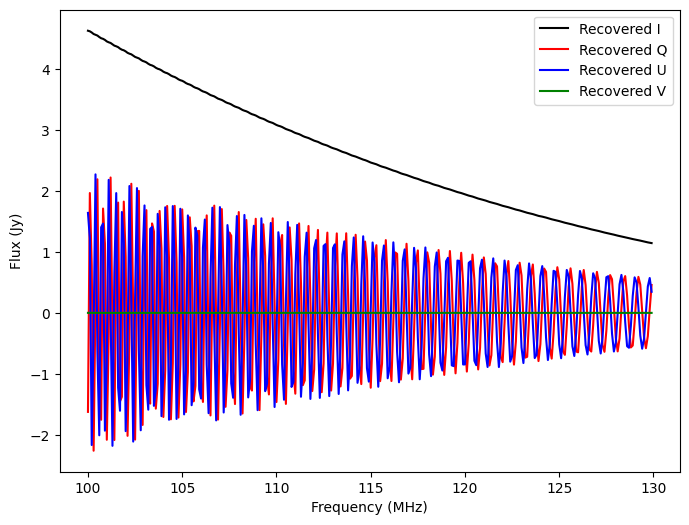

In [8]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_OSKAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

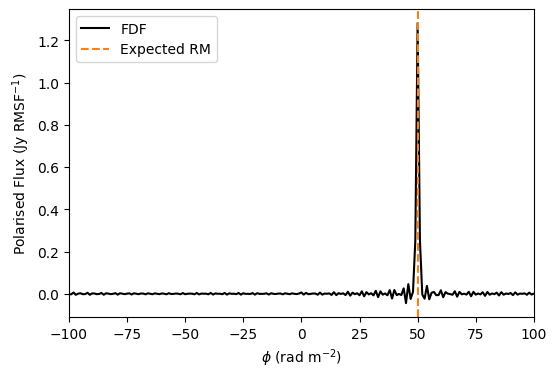

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999887 Expected Pol Fraction 0.5


In [9]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs, atol=0.02)

We recover the correct RM which is nice.

## Test unique primary beam per station

Righto, we'll just run the first four stations as the `skala40_wave` model is slow and I don't have all day. Run it for two time steps, two freqs to check things change sensibly.

After we'll run a full `WODEN` simulation with an off-zenith point source to check that all visibilities are unique. 

In [10]:
##Setup a grid of RA/Dec on the sky
##Setup a grid of RA/Dec on the sky
nside=64
radec_reso = 50/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

all_freqs = np.array([75e+6, 200e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(3*3600.0, format='sec')])
##Do the first four stations
station_ids = np.arange(4)

# lsts = []
# latitudes = []

# for obs_time in all_times:
    
#     LST = obs_time.sidereal_time('mean')
#     lst_current = np.radians(LST.value*15)
    
#     lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
#                                 lst_current,
#                                 np.radians(MWA_LAT),
#                                 obs_time.mjd)
    
#     lsts.append(lst_J2000)
#     latitudes.append(latitude_J2000)

coeff_path=""
ms_path="create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms"
apply_beam_norms = True
iau_order = True
parallactic_rotate = True
element_response = "skala40_wave"

num_threads = 8

all_jones = run_everybeam_over_threads(num_threads,
                            ras, decs,
                            ms_path=ms_path,
                            times=all_times, freqs=all_freqs,
                            station_ids=station_ids,
                            beam_ra0=np.radians(ra0),beam_dec0=np.radians(dec0),
                            apply_beam_norms=apply_beam_norms,
                            iau_order=iau_order,
                            parallactic_rotate=parallactic_rotate,
                            element_response_model=element_response)

Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead70 MHz instead

Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency 75 MHz, using the nearest neighbor with frequency 70 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest neighbor with fr

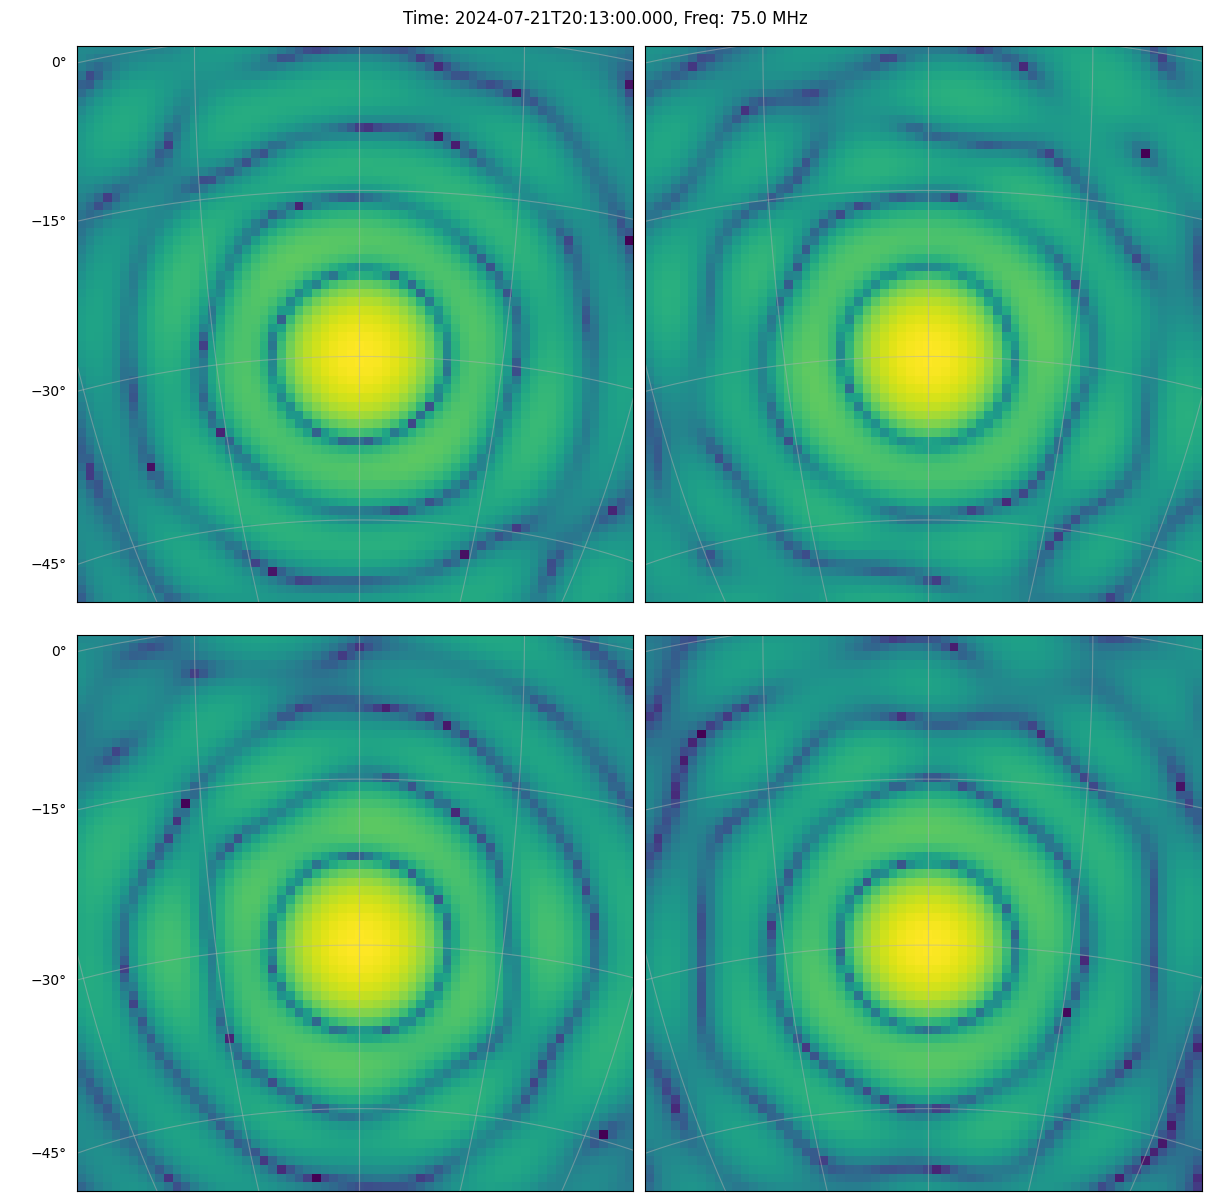

In [11]:
def plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained',
                            subplot_kw={'projection': wcs})
    
    for col in range(2):
        for row in range(2):
            beam_ind = col*2 + row
            
            gx = all_jones[beam_ind, time_ind, freq_ind, :, 0,0]
            gx.shape = (nside, nside)
            
            im = axs[row, col].imshow(np.log10(np.abs(gx)), origin='lower')
            
            axs[row, col].grid(alpha=0.5)
            
            lon = axs[row, col].coords[0]
            lat = axs[row, col].coords[1]
            
            lon.set_ticks_visible(False)
            lat.set_ticks_visible(False)
            lon.set_axislabel(' ')
            lat.set_axislabel(' ')
            
            if col > 0:
                lat.set_ticklabel_visible(False)
            if row < 2:
                lon.set_ticklabel_visible(False)
                
            if col == 2:
                plt.colorbar(im, ax=axs[row, col], label='log10(abs(gx))')
            

    fig.suptitle(f"Time: {all_times[time_ind].isot}, Freq: {all_freqs[freq_ind]/1e+6} MHz")

    plt.show()

time_ind = 0
freq_ind = 0
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

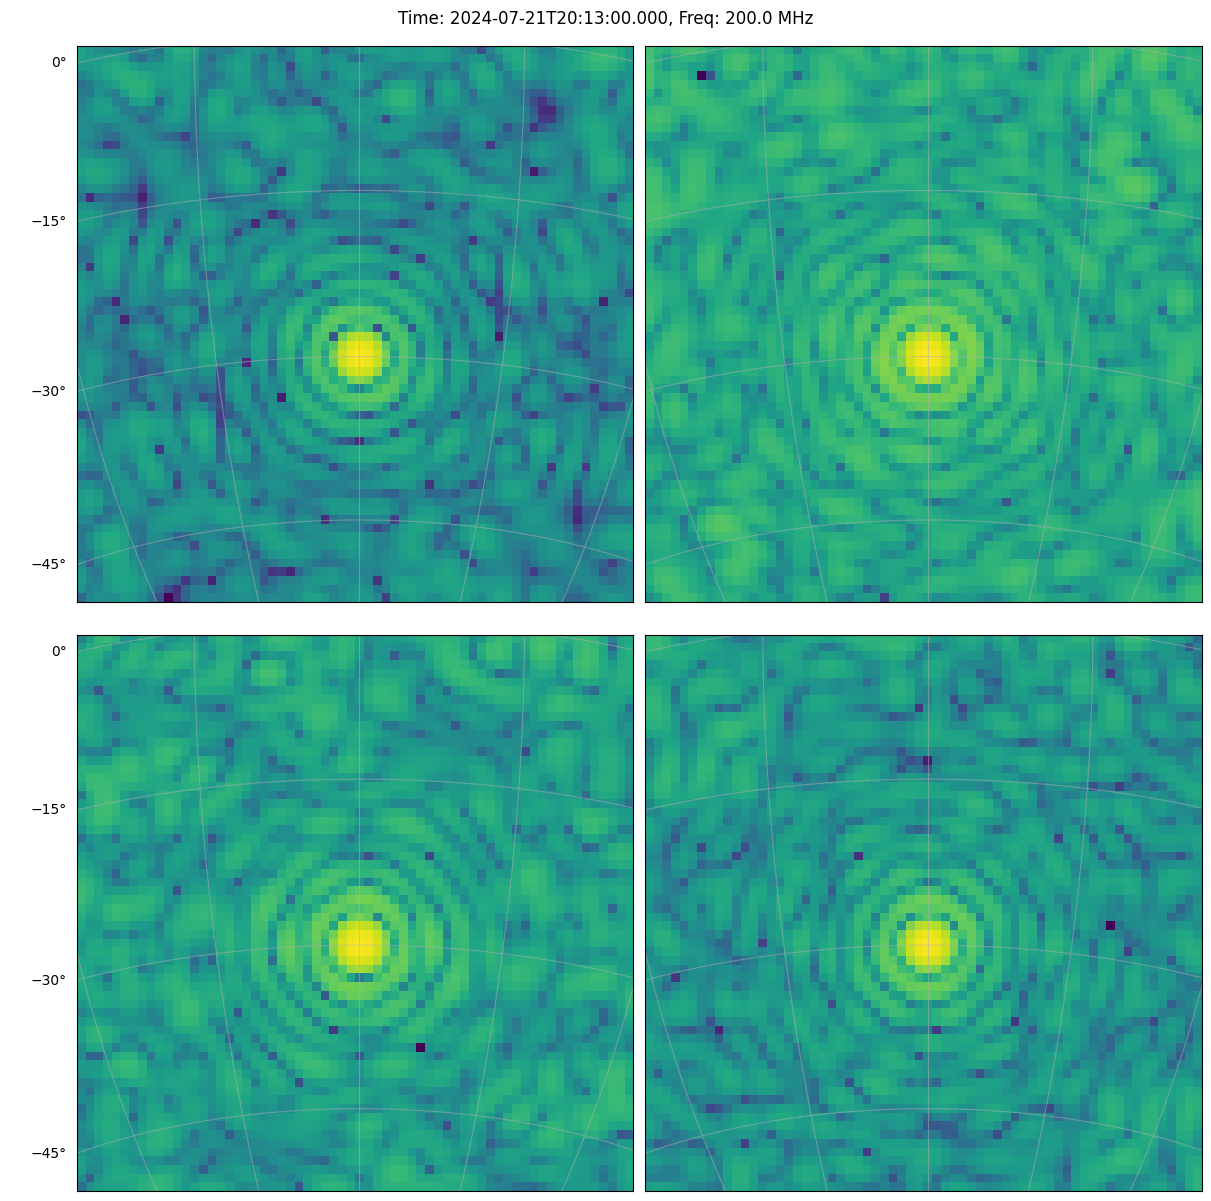

In [12]:
time_ind = 0
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

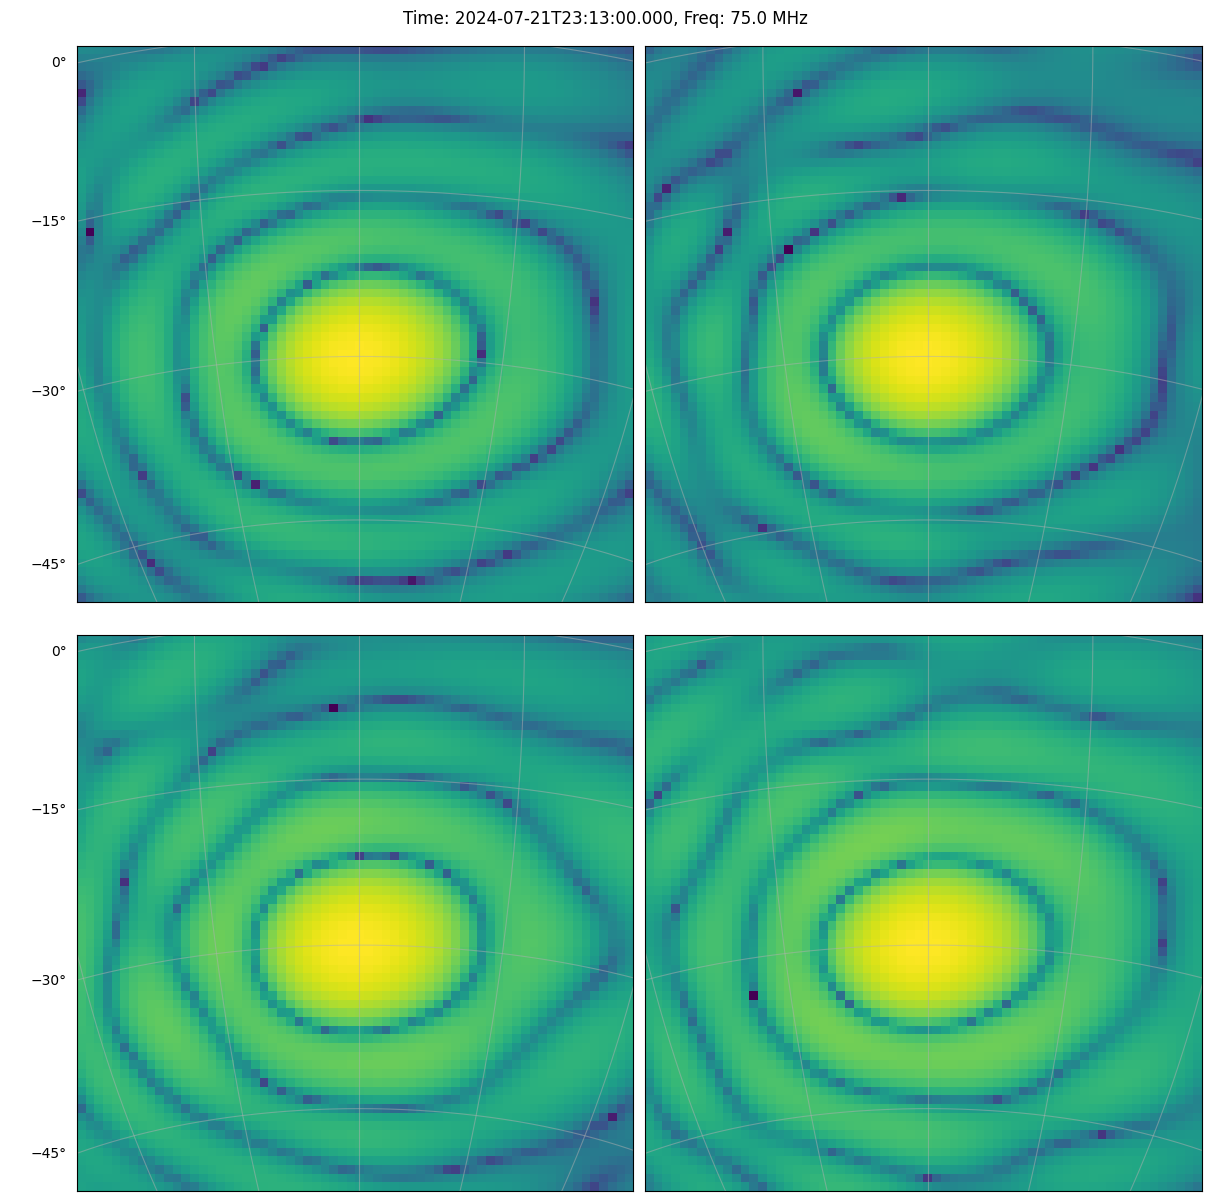

In [13]:
time_ind = 1
freq_ind = 0
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

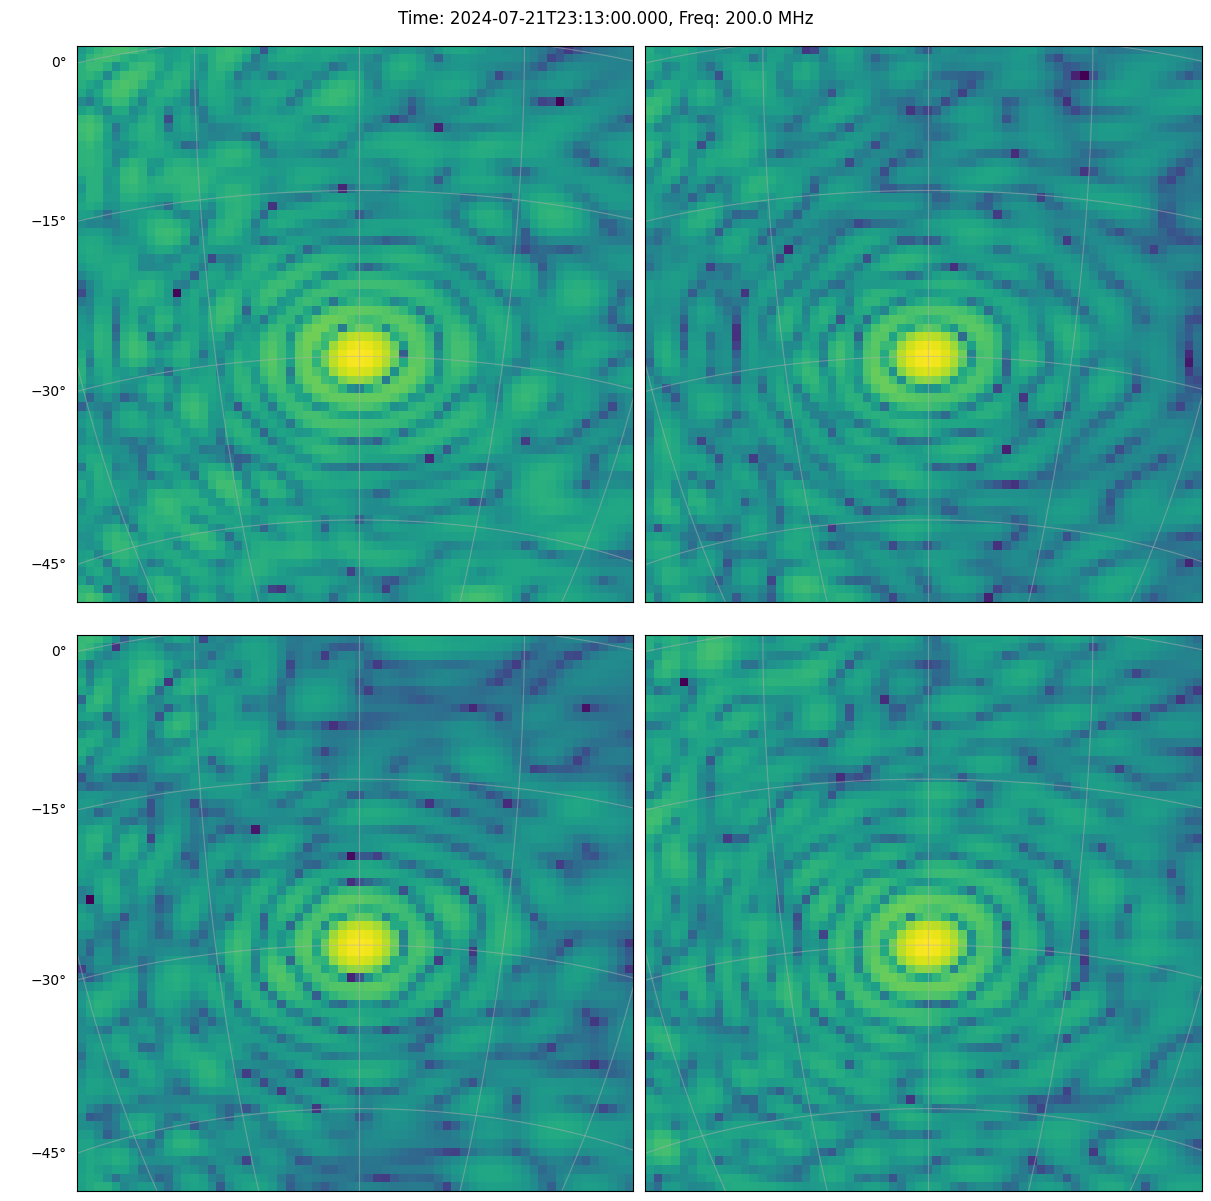

In [14]:
time_ind = 1
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

## Let's make an image
Just create a random sky image of some point sources for fun

In [15]:
ra_coord_hw = 15
dec_coord_hw = 10

num_coords = 500

ras = np.random.uniform(ra0 - ra_coord_hw, ra0 + ra_coord_hw, num_coords)
decs = np.random.uniform(dec0 - dec_coord_hw, dec0 + dec_coord_hw, num_coords)

ras[ras < 0] += 360

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.random.uniform(1, 10, num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

profile_cat = 'profiling_source.fits'

main_table.write(profile_cat, format='fits', overwrite=True)

WARNING: We're running all stations with a unique beam below. There are 512 stations, so many many beams to compute. This simulation took 8 mins 30s on my desktop. If you want a faster version, add `--station_id=0` to the command line arguments in the cell below to just use station 0.

In [24]:
cat_name = "profiling_source.fits"
low_freq = 50e+6
freq_reso = 100e+3
num_freq_chans = 1
uvfits_name = 'ska_image_test'
primary_beam = 'everybeam_OSKAR'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += '--eb_point_to_phase ' ##this overrides whatever pointing is in beam_ms_path
                                  ##and sets it to ra0, dec0
command += f'--latitude={MWA_LAT} --longitude={MWA_LONG} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=2 --IAU_order '
command += ' --cpu_mode '
# command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms'

call(command, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms: 22 columns, 130816 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_ska_image_test_band01.ms::FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
2025-10-22 14:42:51 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
     

0

Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

In [25]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=ska_image_test_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name ska_image_test -size 4096 4096 -niter 2000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.005 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  ska_image_test_band*.ms "

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 4.7435968067838985 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 4.7435968067838985 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and ass


WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  50-50 (1)
Reordering ska_image_test_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for ska_image_test_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for ska_image_test_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[3.24584e-06:47.8641] lambdas, maxuvw=7253.73 lambda)
Theoretic beam = 28.44''
Small inversi

0

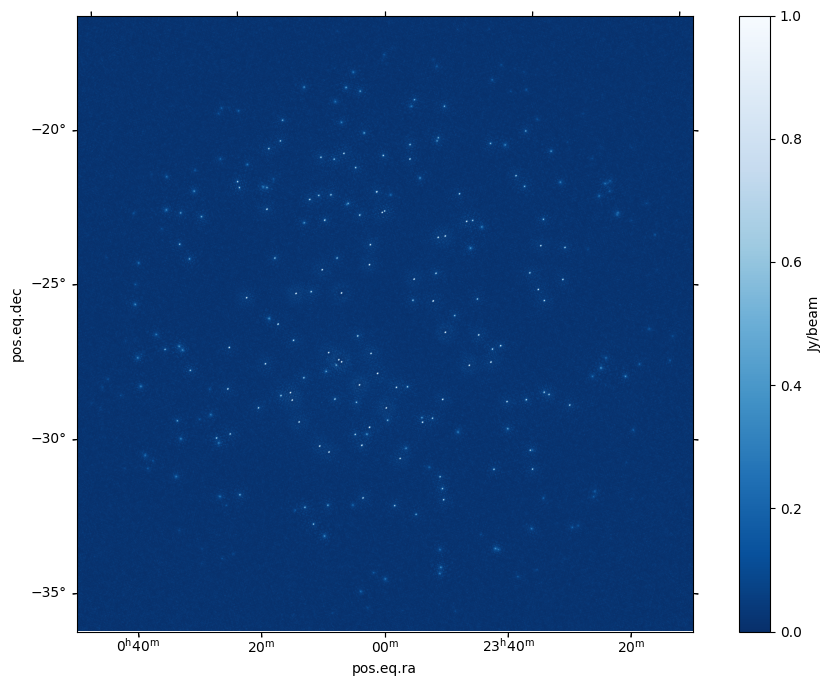

In [26]:
with fits.open('ska_image_test-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 2000
mid = 2048

axs.set_xlim(mid-half_width, mid+half_width)
axs.set_ylim(mid-half_width, mid+half_width)

plt.show()

Pretty incredible image quality, given this is a single frequency channel, and only 2 time steps. We'll overplot the source posisitons to show that the beam is properly down-weighting the sources at image edge.

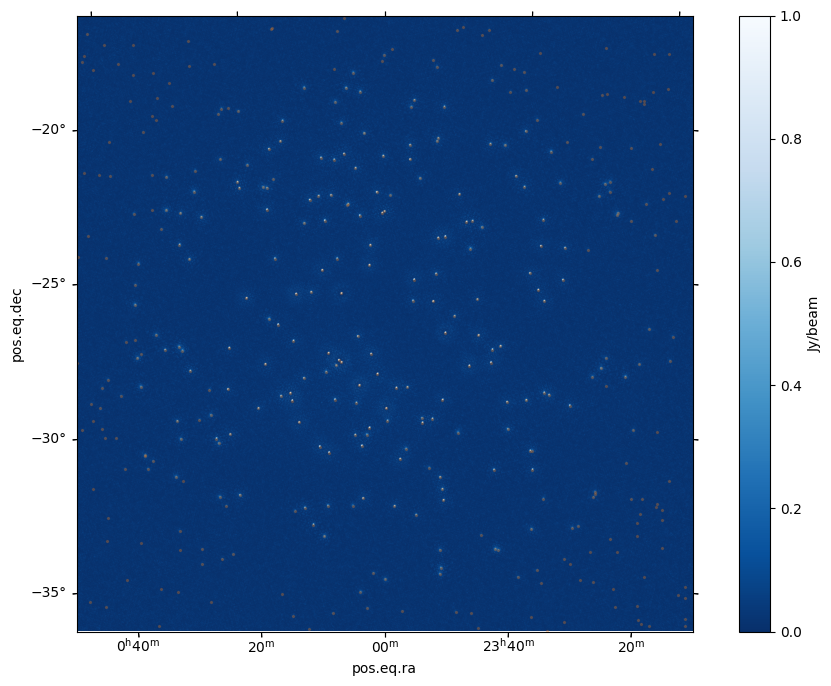

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})


im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

x, y = wcs.all_world2pix(ras, decs, 0)
axs.scatter(x, y, s=2, c='C1', marker='x', alpha=0.3)

half_width = 2000
mid = 2048

axs.set_xlim(mid-half_width, mid+half_width)
axs.set_ylim(mid-half_width, mid+half_width)

plt.show()

Out of interest, what does the PSF look like?

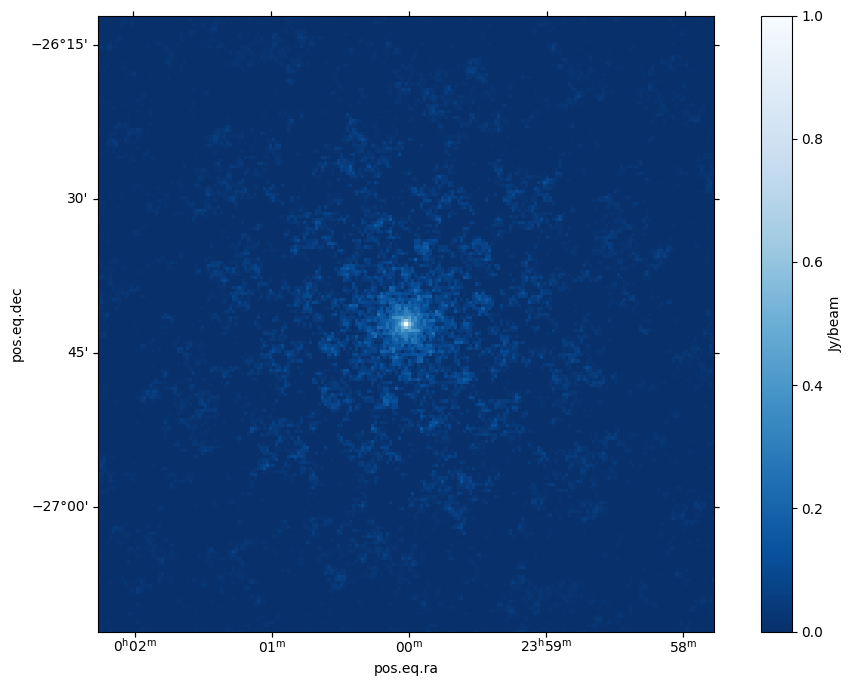

In [28]:
with fits.open('ska_image_test-psf.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 100
mid = 2048

axs.set_xlim(mid-half_width, mid+half_width)
axs.set_ylim(mid-half_width, mid+half_width)

plt.show()

Like a snowflake, pretty cool.